<a href="https://colab.research.google.com/github/rifqoi/BERT-Sentiment-Analysis/blob/main/11-indoberttweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
!wget https://raw.githubusercontent.com/datascienceid/stopwords-bahasa-indonesia/master/stopwords_id_satya.txt -O stopword.txt
!wget https://cdn.discordapp.com/attachments/818681954303868938/995913295154393148/bismillah.json

--2022-07-11 16:57:43--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49923 (49K) [text/plain]
Saving to: ‘kamus_alay.csv’

kamus_alay.csv      100%[===================>]  48.75K  --.-KB/s    in 0.001s  

2022-07-11 16:57:43 (38.3 MB/s) - ‘kamus_alay.csv’ saved [49923/49923]

--2022-07-11 16:57:43--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 

In [2]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 26.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=b8d937ad8c2350438da76976b77a364177be7bdcfb7997f355f6add505981b08
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 31.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 18.7 MB/s 
     |████████████████████████████████| 101 kB 12.1 MB/s 
     |████████████████████████████████| 596 kB 49.8 MB/s 
     |████████████████████████████████| 6.6 MB 49.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.1

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict
import string

# NLP
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

import tensorflow as tf

from transformers import TFBertForSequenceClassification, BertConfig, BertTokenizer, TFAutoModelForSequenceClassification, TFAutoModel
from transformers import InputExample, InputFeatures
import transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Import data
df = pd.read_json("bismillah.json")

In [5]:
df = df.sample(frac=1)

In [6]:
df = df[["tweets", "sentiment"]]
df

,tweets,sentiment
3055,Saya yakin ini Jakarta. Tapi belum bisa percay...,Positive
3724,FORMULA E JAKARTA PECAHKAN REKOR PENONTON TERB...,Positive
1571,Tiket Formula E Jakarta Dijual Mulai Maret? Ti...,Negative
3110,Bisa begitu ya #FormulaESuksesMendunia mendat...,Positive
3973,"Formula E? Kesabaran, juga diadakan, Mandalika...",Neutral
...,...,...
2115,"udahlah udh cape beginian, toh itu dukun agama...",Positive
157,"Pertanyaan aneh. Sama seperti event"" lainnya p...",Positive
4165,Ananda Mikola menyebut sirkuit Formula E Jakar...,Neutral
3958,"Eh Smart, mereka yang memiliki kekuatan untuk ...",Neutral


In [7]:
df.tweets = df.tweets.apply(lambda x: x.lower())
df

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,tweets,sentiment
3055,saya yakin ini jakarta. tapi belum bisa percay...,Positive
3724,formula e jakarta pecahkan rekor penonton terb...,Positive
1571,tiket formula e jakarta dijual mulai maret? ti...,Negative
3110,bisa begitu ya #formulaesuksesmendunia mendat...,Positive
3973,"formula e? kesabaran, juga diadakan, mandalika...",Neutral
...,...,...
2115,"udahlah udh cape beginian, toh itu dukun agama...",Positive
157,"pertanyaan aneh. sama seperti event"" lainnya p...",Positive
4165,ananda mikola menyebut sirkuit formula e jakar...,Neutral
3958,"eh smart, mereka yang memiliki kekuatan untuk ...",Neutral


In [8]:
count = 0
for x in df.itertuples():
  if count == 10:
    break
  print(x.tweets)
  count += 1

saya yakin ini jakarta. tapi belum bisa percaya sebagus dan sehijau ini. kombinasi event dan lokasi yang sempurna.
formula e jakarta pecahkan rekor penonton terbanyak, sahroni: dunia melihat indonesia
tiket formula e jakarta dijual mulai maret? tidak rasional #pdiperjuangan
bisa begitu ya #formulaesuksesmendunia  mendatang banyak keuntungan umkm. kalau mandalika knp pada menjerit umumnya. hebat #formulaejakarta  dong.
formula e? kesabaran, juga diadakan, mandalika pertama. atau kereta cepat jakarta bandung, eh salah, ternyata disunat sampai naik, jaraknya berkurang dalam biaya meningkatkan biaya biaya
penyelenggara formula e, pt jakarta propertindo atau jakpri dan imi kirim utusan ke diriyah, arab saudi untuk pelajari cara bikin event. #formulae
mudah²an  tidak lips service,mengingat kebocoran apbd dki sdh terlalu banyak,mulai lem aibon,pulpen,alat pemadam &amp; formula e. si  terlalu sibuk pencitraan kpk mendadak blak-blakan bahas korupsi di dki jakarta, ada apa?
ini adalah anggota de

In [9]:
def clean_data(x):
    x = x.lower()
    # Menghapus @username
    x = re.sub(r"@[A-Za-z0-9]\w+", "", x)  # Remove @
    # Menghapus link website
    x = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", x)  # Remove http links
    # Menghapus new line
    x = re.sub(r"\n", " ", x)
    # Menghapus whitespace pada sekitar kalimat
    x = x.strip()
    # Menghapus hashtag
    x = re.sub(r"\B(#\w+)+", r" ", x)
    # Mengubah % menjadi persen
    x = re.sub(r"(\d+) ?%", "\\1 persen", x)
    # Mengubah emoji menjadi kata 
    x = emoji.demojize(x, delimiters=(" ", " ")) 
    # Menghapus simbol-simbol
    x = re.sub(r"[^\w]", " ", x)
    # Menghapus huruf berulang 
    x = re.sub(r'(.)\1+', r'\1\1', x)     
    # Menghapus spasi berulang
    x = re.sub('\s+', ' ', x)

    return x


In [10]:
kamus_alay = pd.read_csv('kamus_alay.csv')

alay_word_dict = {}

for ele in kamus_alay.itertuples():
  alay_word_dict[ele.slang] = ele.formal

# Custom kata alay wokwokw
custom_word = {
    "bong": "cebong",
    "bongg": "cebong",
    "cebi": "cebong",
    "cebii": "cebong",
    "drun": "kadrun",
    "drunn": "kadrun",
    "druunn": "kadrun",
    "gabener": "gubernur",
    "gabenerr": "gubernur",
    "goodbener": "gubernur",
    "goodbenerr": "gubernur",
    "gotbener": "gubernur",
    "gub": "gubernur",
    "gutbener": "gubernur",
    "gutbenerr": "gubernur",
    "even": "event",
    "komitmen":  "commitment",
    "komitmenn":  "commitment",
    "komitmeen":  "commitment",
    "commitmentt": "commitment",
    "committmeentt": "commitment",
    "ayoo": "ayo",
    "ayok": "ayo",
    "ayook": "ayo",
    "ayokk": "ayo",
    "ayookk": "ayo",
    "kuy": "ayo",
    "kuyy": "ayo",
    "knapa": "kenapa",
    "knapaa": "kenapa",
    "knp": "kenapa",
    "knpa": "kenapa",
    "knpaa": "kenapa",
    "nggak": "enggak",
    "nggaak": "enggak",
    "nggakk": "enggak",
    "nggaakk": "enggak",
    "enggak": "enggak",
    "enggakk": "enggak",
    "enggaak": "enggak",
    "enggaakk": "enggak",
    "tidak": "enggak",
    "nis": "anies",
    "niss": "anies",
    "nies": "anies",
    "niess": "anies",
    "niies": "anies",
    "niiees": "anies",
    "niieess": "anies",
    "anis": "anies",
    "aniss": "anies",
    "aniis": "anies",
    "aniiss": "anies",
    "aniess": "anies",
    "aniiess": "anies",
}

alay_word_dict.update(custom_word)

def normalize_text(x):
  # Ubah kata alay menjadi formal
  x = [alay_word_dict[word] if word in alay_word_dict else word for word in x]

  return x


In [11]:
# Stopwords
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('indonesian'))

negation_words = ['tak', 'tidak', 'gak', 'enggak', 'nggak', 'jangan', 'bukan']
strong_words = ["sekali", 'sangat', 'terlalu', 'amat', 'benar', 'makin']
other_words = ["hari", "jauh", "siapa", "kenapa", "bagaimana", "dapat", "dapatkah", "apa", "kapan", "mengapa", ]
stopwords_to_remove = [negation_words, strong_words, other_words]

with open('./stopword.txt') as f:
  custom_stopwords = f.read().splitlines()

for words_list in stopwords_to_remove:
  for word in words_list:
    stopwords_list.discard(word)

def remove_stopwords(x):
  x = [word for word in x if word not in stopwords_list]
  return x

print(len(stopwords_list))
print(len(custom_stopwords))

737
357


In [12]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stemmer.stem("mengembalikan")
def stemming_text(x):
  x = [stemmer.stem(word) for word in x]
  return x

# df_stemmed = df_stripped_stopwords.copy()
# df_stemmed["tweets"] = df_stemmed.tweets.apply(stemming_text)
# df_stemmed

In [13]:
def preprocess_data(df, stem=False):
  df_processed = df.copy()
  df_processed.tweets = df_processed.tweets.apply(clean_data)
  df_processed.tweets = df_processed.tweets.apply(word_tokenize)
  df_processed.tweets = df_processed.tweets.apply(normalize_text)
  df_processed.tweets = df_processed.tweets.apply(remove_stopwords)
  if stem:
    df_processed.tweets = df_processed.tweets.apply(stemming_text)
  df_processed.tweets = df_processed.tweets.apply(lambda x: ' '.join(x))
  df_processed.sentiment = df_processed.sentiment.map({
    "Positive": 0,
    "Neutral": 1,
    "Negative": 2,
  })
  return df_processed

df_preprocessed = preprocess_data(df)
df_preprocessed

,tweets,sentiment
3055,jakarta percaya sebagus sehijau kombinasi even...,0
3724,formula e jakarta pecahkan rekor penonton sahr...,0
1571,tiket formula e jakarta dijual maret enggak ra...,2
3110,ya keuntungan umkm mandalika kenapa menjerit h...,0
3973,formula e kesabaran diadakan mandalika kereta ...,1
...,...,...
2115,cape dukun agamanya bikin islam siap2 ya benta...,0
157,aneh event pastinya rakyat bahagia eventnya be...,0
4165,ananda mikola menyebut sirkuit formula e jakar...,1
3958,eh smart memiliki kekuatan membangun ptm benar...,1


In [14]:
def make_corpus(column):
    
    text_body = ""


    for sentences in column:
      sentences = sentences.split(' ')
      text_body += ' ' +' '.join(sentences)

    print(text_body)
    # transform list of words into 1 body of text
    corpus = re.sub('[ ]+',' ', text_body) # replace double whitespace with one
        
    return corpus

In [15]:
# Takes a while
corpus = make_corpus(df_preprocessed.tweets)

 jakarta percaya sebagus sehijau kombinasi event lokasi sempurna formula e jakarta pecahkan rekor penonton sahroni dunia indonesia tiket formula e jakarta dijual maret enggak rasional ya keuntungan umkm mandalika kenapa menjerit hebat formula e kesabaran diadakan mandalika kereta cepat jakarta bandung eh salah disunat jaraknya berkurang biaya meningkatkan biaya biaya penyelenggara formula e pt jakarta propertindo jakpri imi kirim utusan diriyah arab saudi pelajari bikin event mudah²an enggak lips service kebocoran apbd dki terlalu lem aibon pulpen alat pemadam amp formula e sih terlalu sibuk pencitraan kpk mendadak blak blakan bahas korupsi dki jakarta apa anggota dewan mengapa mengurus formula e rolling_on_the_floor_laughing rolling_on_the_floor_laughing rolling_on_the_floor_laughing rolling_on_the_floor_laughing rolling_on_the_floor_laughing rolling_on_the_floor_laughing rolling_on_the_floor_laughing rolling_on_the_floor_laughing enggak bahas komentari borobudur asyik bergembira ria 

In [16]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 9777


In [17]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples 
    
    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})
    
    return df

In [18]:
corpus_freq = word_freq(corpus, top=20)

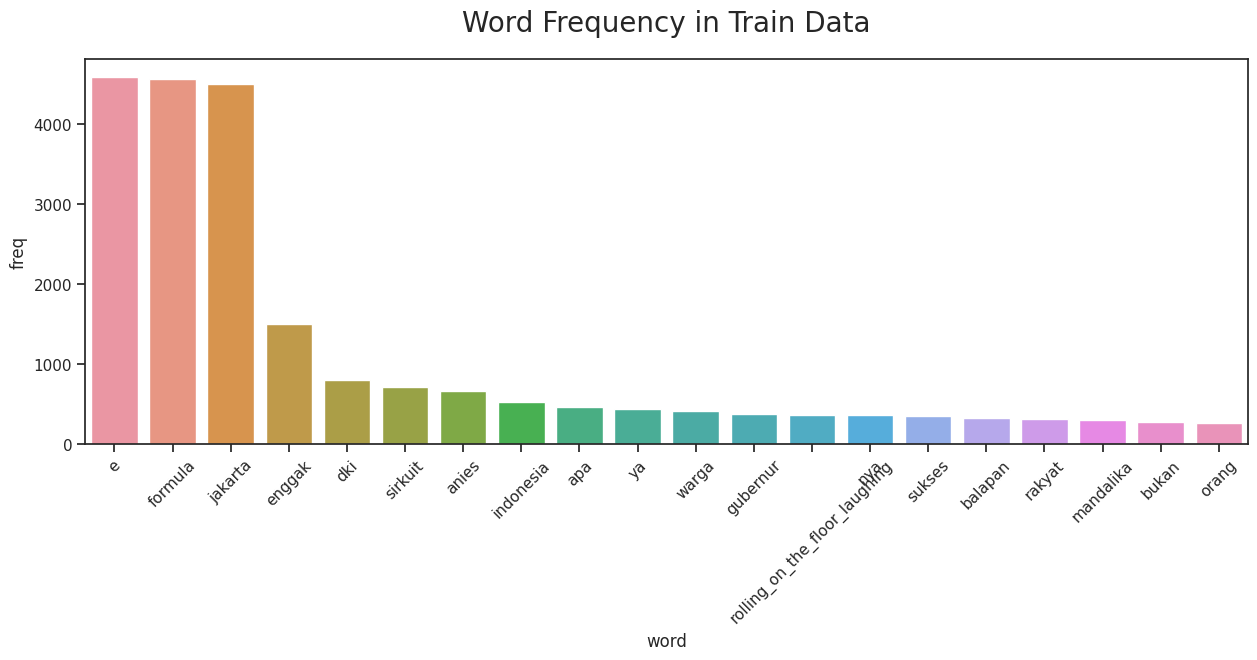

In [19]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

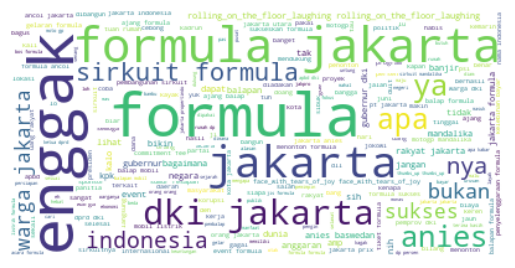

In [20]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [36]:
# train val split
train_set, val_set = train_test_split(df_preprocessed, test_size=0.2, stratify=df_preprocessed.sentiment)
val_set, test_set = train_test_split(val_set, test_size=0.5, shuffle=False)

In [22]:
def convert_data_to_examples(input_set,  DATA_COLUMN, LABEL_COLUMN):
  set_InputExamples = input_set.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  return set_InputExamples


In [23]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [24]:
def convert_data_to_tf_dataset(train, val, data_column, label_column, tokenizer):
  train_InputExamples = convert_data_to_examples(train, data_column, label_column)
  validation_InputExamples = convert_data_to_examples(val, data_column, label_column)
  
  train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
  train_data = train_data.shuffle(100).batch(32).repeat(2)
  
  validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
  validation_data = validation_data.batch(32)
  return train_data, validation_data


In [37]:
def bert_model(pretrained_model, from_pt=False):
  tokenizer = BertTokenizer.from_pretrained(pretrained_model)
  config = BertConfig.from_pretrained(pretrained_model)
  config.labels = 3
  
  base_model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=3, from_pt=from_pt)
  return base_model, tokenizer
model, tokenizer = bert_model('indolem/indobertweet-base-uncased', from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
DATA_COLUMN = 'tweets'
LABEL_COLUMN = 'sentiment'

train_data, validation_data = convert_data_to_tf_dataset(train_set, val_set, DATA_COLUMN, LABEL_COLUMN, tokenizer)

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-6, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_data, epochs=7, validation_data=validation_data)

Epoch 1/7
210/210 [==============================] - 194s 821ms/step - loss: 0.9735 - accuracy: 0.5581 - val_loss: 0.7929 - val_accuracy: 0.7002
Epoch 2/7
210/210 [==============================] - 170s 808ms/step - loss: 0.7056 - accuracy: 0.7224 - val_loss: 0.6467 - val_accuracy: 0.7434
Epoch 3/7
210/210 [==============================] - 171s 812ms/step - loss: 0.5735 - accuracy: 0.7754 - val_loss: 0.6161 - val_accuracy: 0.7554
Epoch 4/7
210/210 [==============================] - 170s 808ms/step - loss: 0.4834 - accuracy: 0.8142 - val_loss: 0.5928 - val_accuracy: 0.7554
Epoch 5/7
210/210 [==============================] - 170s 808ms/step - loss: 0.4051 - accuracy: 0.8504 - val_loss: 0.6092 - val_accuracy: 0.7650
Epoch 6/7
210/210 [==============================] - 170s 807ms/step - loss: 0.3374 - accuracy: 0.8814 - val_loss: 0.6133 - val_accuracy: 0.7842
Epoch 7/7
210/210 [==============================] - 170s 807ms/step - loss: 0.2794 - accuracy: 0.9043 - val_loss: 0.6262 - val_ac

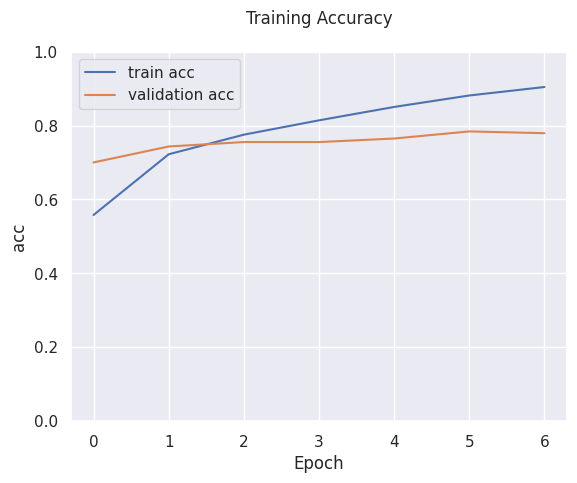

In [44]:
sns.set()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.title('Training Accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

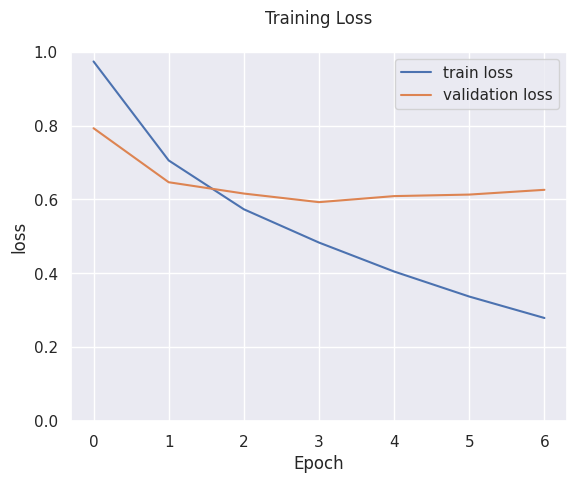

In [40]:
sns.set()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [41]:
test_sentences = list(test_set["tweets"])
tf_batch = tokenizer(test_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels =  ["Positive", "Neutral", "Negative"]
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
test_pred = []
for i in range(len(test_sentences)):
  test_pred.append(label[i])
print(test_pred)

[2, 0, 0, 1, 2, 2, 0, 0, 1, 2, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 0, 2, 1, 2, 1, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0, 0, 1, 2, 1, 2, 1, 1, 2, 2, 0, 1, 1, 2, 1, 2, 0, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 0, 1, 1, 0, 0, 0, 2, 1, 0, 1, 2, 0, 2, 2, 1, 0, 2, 1, 0, 0, 2, 2, 2, 2, 2, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 0, 1, 0, 2, 1, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2, 0, 2, 1, 0, 2, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 2, 1, 1, 0, 2, 0, 2, 1, 0, 0, 0, 1, 0, 2, 2, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2, 0, 2, 1, 1, 2, 0, 1, 0, 0, 2, 0, 1, 0, 2, 1, 1, 2, 2, 0, 2, 0, 2, 1, 1, 0, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 0, 0, 1, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 0, 1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 1, 2, 1, 0, 1, 0, 1, 1, 0, 1, 0, 2, 1, 2, 0, 2, 2, 0, 1, 1, 0, 1, 1, 

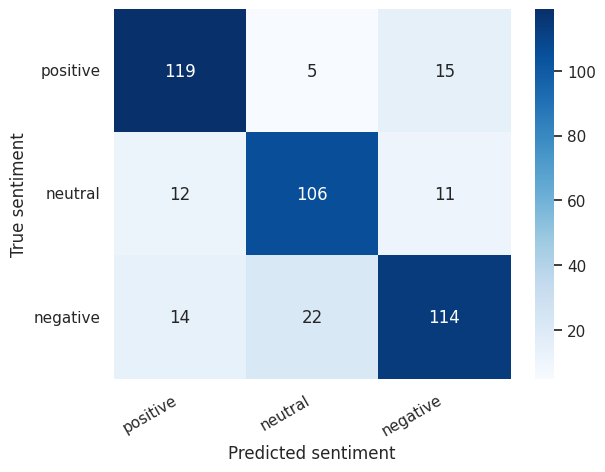

In [42]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(test_set.sentiment, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [43]:
print(classification_report(test_set.sentiment, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.82      0.86      0.84       139
     neutral       0.80      0.82      0.81       129
    negative       0.81      0.76      0.79       150

    accuracy                           0.81       418
   macro avg       0.81      0.81      0.81       418
weighted avg       0.81      0.81      0.81       418

